Covid-19_and_Pneumonia_X-Ray_Detector

In [2]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, cohen_kappa_score, recall_score, f1_score

In [17]:
import cv2
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
from tensorflow.keras.optimizers import Adam

In [6]:
# Load, scale and prepare train sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.5 MB/s 


In [10]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
# from tensorflow_addons.losses import WeightedKappaLoss # ??? Ordinal?

In [8]:
# resNet50
# from tensorflow.keras.applications.resnet50 import ResNet50
# ModuleNotFoundError: No module named 'tensorflow.keras.application'

# Functions

In [11]:
def listdir_nohidden(path):
  """ returns a list of no hidden folders in a path
  in this case the folders are sorted as the are classes of a images
  (and later will be used as an iterator...)"""
  # import os

  folders = []
  for f in os.listdir(path):
    if not f.startswith('.'):
      # yield f # returns a generator (iterable)
      folders += [f]
  return sorted(folders)


In [12]:
def plot_metric(history, metric):
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set
    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.yscale('log')
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# Description

### Identify COVID by x-RAy  
Dectect and classify chest illneses.  
Reduce costs and detection time.  
Have a pre-diagnosis in minutes. Increase survival rate.  
Categories:  
* Healthy
* Covid-19
* Bacterial Pneumonia
* Viric Pneumonia   


### Data info
custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.Each class contains 133 images.  
  
data from https://github.com/ieee8023/covid-chestxray-dataset and https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.  
created by frogames.    

0 - Covid-19

1 - Normal X-ray

2 - Viral Pneumonia X-ray

3 - Bacterial Pneumonia X-ray


# Load Data

In [18]:
# !!! change dir
# allows to work with relative paths in all the notebook
os.chdir('/content/drive/MyDrive/ironhack-finalProject')

In [12]:
train_path = 'data_train'

In [13]:
# Scan folders in train_path
# os.listdir(train_path)
listdir_nohidden(train_path)

['0', '1', '2', '3']

In [14]:
datagen_load = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2)

In [15]:
# Question 
# ??? rescale --> I think it min_max_scale the values of the pixels in the image
# between 0 and 1


In [16]:
load_generator = datagen_load.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "training")

Found 428 images belonging to 4 classes.


In [17]:
# Question
# !!! flow_from_directory Deprecated?
# classes?

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [18]:
# test_path = '/content/drive/MyDrive/ironhack-finalProject/data_test'

In [19]:
# Define validation subset
# After validation split en image_generator
load_validation = datagen_load.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "validation")


Found 104 images belonging to 4 classes.


In [20]:
# 133*4, 133*4*0.8, 133*4*0.2

In [21]:
train_images, train_labels = next(load_generator)

In [22]:
# Question
# ??? next?
# https://datascience.stackexchange.com/questions/88737/keras-next-what-does-2-256-128-128-3-mean

In [23]:
# train_generator.shape

In [24]:
train_images.shape

(40, 256, 256, 3)

In [25]:
train_labels.shape

(40, 4)

In [26]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [27]:
# We are assuming that is not possible to have two illneses at the same time

In [28]:
label_names = {0:'covid', 1:'normal', 2: 'viral', 3:'bacterial'}

# Visualize images

In [29]:
#L = 6
#W = 6
#range(L*W)

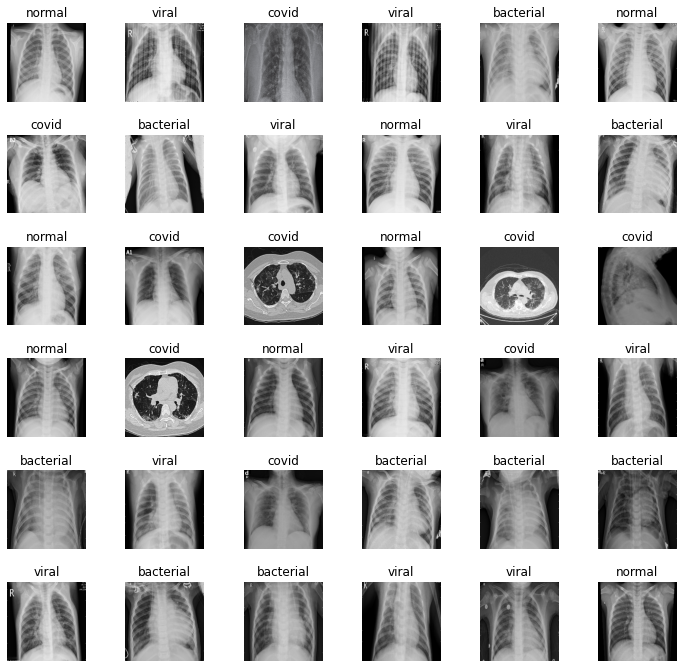

In [30]:
# Create matrix of images
L = 6
W = 6

fig, ax = plt.subplots(L, W, figsize = (12,12))
ax = ax.ravel() # it flattens the axes and allows to make a for loop

for i in range(L*W):
  ax[i].imshow(train_images[i])
  ax[i].set_title(label_names[np.argmax(train_labels[i])])
  ax[i].axis('off')

plt.subplots_adjust(wspace=0.5)

In [31]:
# 120*5*5

# Build the CNN 0

## Convolutional architecture

In [19]:
# Initialize the CNN
cls = Sequential()

In [20]:
# Add Convolution Layer
# cls.add(Conv2D(32, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))
cls.add(Conv2D(9, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))

In [21]:
# classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# input shape necessary when not all the pictures are squared.

In [22]:
# Question
# ??? padding, --> acolchado/ relleno en el input. if padding "same" and strides = 1
# then input size and output size will be the same
# ??? strides, --> zancadas o avances. i.e [i,2,2,1] (if window 2x2 no overlaping)
# ??? dilation_rate...

In [23]:
# Add Max Pooling (spatial subsampling)
# Very important define well the pool_size
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))

In [37]:
# average pooling 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D

In [24]:
# Flattening
cls.add(Flatten())

## Fully-connected layers

In [25]:
# Dense Layers
#cls.add(Dense(units = 256, activation = 'relu'))
#cls.add(Dense(units = 128, activation = 'relu'))
cls.add(Dense(units = 64, activation = 'relu'))


In [26]:
# Dropout Layers
cls.add(Dropout(0.2, seed = 0))

In [27]:
# Classification Layer
cls.add(Dense(units = 4, activation = 'softmax'))

In [42]:
# 84/120

In [43]:
# ??? How long is the flaten layer?
# units --> positive integer, dimensionality of the output space

In [44]:
# 256*2

## Save model Weights0 - no compiled

In [28]:
cls.save('models/xRay_aug_w0.hdf5')

## Compile CNN

In [45]:
cls.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics=['accuracy','Precision','Recall',CohenKappa(num_classes=4)])

In [46]:
# Question
# compile --> monta la estructura y el optimizador
# el optimizador busca los mejores pesos para conseguir que la función de loss 
# sea lo más pequeña posible. Y la función de loss depende las funciones de activacion



In [47]:
#cls.summary()

In [48]:
cls.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 9)       684       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 9)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 9)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35721)             0         
                                                                 
 dense (Dense)               (None, 64)                2286208   
                                                                 
 dropout (Dropout)           (None, 64)                0

In [79]:
cls.metrics_names

['loss', 'accuracy', 'precision', 'recall', 'cohen_kappa']

## define kappa loss

In [49]:
# kappa_loss = CohenKappa(num_classes=4) #, )

## define callbacks

In [50]:
# Define callbacks

In [51]:
checkpoint_path = 'models/cnn_cls-augmented.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_freq='epoch', # How often the checkpoint file will be saved.
    save_weights_only=False, # Wether or not to save just the weitgths of each neuron.
    save_best_only = True, 
    # it only saves when the model is considered the "best" and the latest 
    # best model according to the quantity monitored will not be overwritten
    verbose=1 # To display the progress
)

In [52]:
early_stopping = EarlyStopping(monitor = "val_loss", # mode = 'min', kappa_metric, 
                               patience=15, verbose=1) 


# Train and validation generator.  
??? Different batch size.  


In [53]:
img_generator_train = ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True) #,
                                         #validation_split = 0.2)
                                         

img_generator_val = ImageDataGenerator(rescale = 1./255) #validation_split = 0.2)

In [54]:
# generate the train and test with different batch size
train_generator = img_generator_train.flow_from_directory(batch_size = 4,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical")#,
                                                      #subset = "training")

Found 532 images belonging to 4 classes.


In [55]:
val_generator = img_generator_val.flow_from_directory(batch_size = 4,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical")#,
                                                      #subset = "validation")

Found 532 images belonging to 4 classes.


# fit_generator train_data

In [56]:
history = cls.fit_generator(
    train_generator, 
    validation_data=val_generator,
    steps_per_epoch= train_generator.n//4,
    epochs=30, # Number of epochs. 
    #validation_split=0.20, # Here the TRAIN set will be split in TRAIN = TRAIN_NEW + VALIDATION. TRAIN_NEW used 
    # for train and val for CV
    #batch_size=20, # How many samples to input in the network before updating the weights
    #verbose=2, # To display the progress.
    callbacks=[early_stopping,checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 1.3336 - accuracy: 0.5094 - precision: 0.5500 - recall: 0.1447 - cohen_kappa: 0.3459
Epoch 1: val_loss improved from inf to 0.84677, saving model to models/cnn_cls-augmented.hdf5
133/133 [==============================] - 63s 451ms/step - loss: 1.3336 - accuracy: 0.5094 - precision: 0.5500 - recall: 0.1447 - cohen_kappa: 0.3459 - val_loss: 0.8468 - val_accuracy: 0.7143 - val_precision: 0.8404 - val_recall: 0.4850 - val_cohen_kappa: 0.6190
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.6992 - precision: 0.8029 - recall: 0.5132 - cohen_kappa: 0.5990
Epoch 2: val_loss improved from 0.84677 to 0.62247, saving model to models/cnn_cls-augmented.hdf5
133/133 [==============================] - 49s 372ms/step - loss: 0.8335 - accuracy: 0.6992 - precision: 0.8029 - recall: 0.5132 - cohen_kappa: 0.5990 - val_loss: 0.6225 - val_accuracy: 0.7707 - val_precision: 0.8086 - val_recall: 0.6

In [57]:
# Steps per epoch: images in data_train (train_generator) / batch size

In [61]:
print(history.params)

{'verbose': 1, 'epochs': 30, 'steps': 133}


In [62]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'cohen_kappa', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_cohen_kappa'])


# Evaluate Model

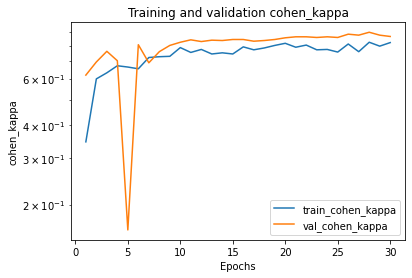

In [64]:
plot_metric(history, 'cohen_kappa')

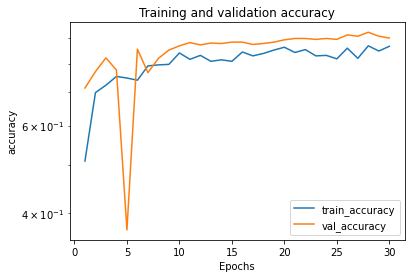

In [65]:
plot_metric(history, 'accuracy')

# Generate Test Set

In [66]:
test_path = 'data_test'

In [67]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [69]:
test_generator = test_gen.flow_from_directory(directory=test_path,
                                              target_size = (256,256),
                                              class_mode = "categorical",
                                              batch_size=4,
                                              shuffle=True,
                                              seed = 0,
                                              )

Found 40 images belonging to 4 classes.


# Evaluate Test

In [70]:
evaluate = cls.evaluate_generator(test_generator, 
                                  steps = test_generator.n//4,
                                  verbose = 1)

print('Accuracy in test: {}'.format(evaluate[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


10/10 [==============================] - 12s 1s/step - loss: 0.6035 - accuracy: 0.7750 - precision: 0.7750 - recall: 0.7750 - cohen_kappa: 0.7000
Accuracy in test: 0.7749999761581421


In [71]:
evaluate

[0.6034961342811584,
 0.7749999761581421,
 0.7749999761581421,
 0.7749999761581421,
 0.699999988079071]

In [72]:
cls.metrics_names

['loss', 'accuracy', 'precision', 'recall', 'cohen_kappa']

# Prediction

In [80]:
# from sklearn.metrics import...

prediction = []
original = []
image = []
items = []

for i in range(len(listdir_nohidden(test_path))):
  for item in os.listdir(os.path.join(test_path, str(i))):
    items.append(item)
    img = cv2.imread(os.path.join(test_path, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img/255 # manually scale between 0 and 1
    img = img.reshape(-1, 256, 256, 3) # our CNN was trained with batchs
    predict = cls.predict(img) # just predict 
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

results = pd.DataFrame({'image':items, 'category':original, 'prediction':prediction})

In [74]:
len(original)

40

In [ ]:
#len(listdir_nohidden(test_path))

In [81]:
score = accuracy_score(original, prediction)
print('Accuracy on prediction{}'.format(score))

Accuracy on prediction0.775


In [76]:
kappa_pred = cohen_kappa_score(original, prediction)
print('Kappa on prediction{}'.format(kappa_pred))

Kappa on prediction0.775


cohen_kappa 0.699999988079071

# Confusion Matrix

In [77]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.64      0.90      0.75        10
           2       1.00      0.40      0.57        10
           3       0.73      0.80      0.76        10

    accuracy                           0.78        40
   macro avg       0.82      0.77      0.76        40
weighted avg       0.82      0.78      0.76        40



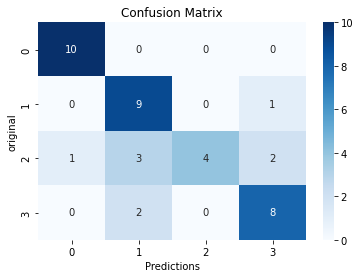

In [78]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('original')
ax.set_title('Confusion Matrix')
plt.show()

# Results

In [91]:
results[results.category != results.prediction][(results.prediction == 1) & (results.category == 3)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,image,category,prediction
35,person3_bacteria_13.jpeg,3,1
37,person3_bacteria_12.jpeg,3,1


# kappa_loss testing

In [103]:
def kappa_loss(y_true, y_pred):
  y_true = np.asarray(y_true)
  y_pred = np.asarray(y_pred)
  #metric = CohenKappa(num_classes = 4)
  #metric.update_state(y_true, y_pred)

  #result = metric.result()
  #return result
  return cohen_kappa_score(y_true, y_pred)

In [93]:
original

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [94]:
prediction

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 0,
 3,
 2,
 2,
 3,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 3]

In [95]:
np.asarray(original)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [96]:
np.asarray(original)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [104]:
kappa_loss(original,prediction)

0.7

# Compute Best Learning Rate

In [14]:
lrs = np.logspace(np.log10(0.000001),np.log10(100), num=48, endpoint=False)
lrs

array([1.00000000e-06, 1.46779927e-06, 2.15443469e-06, 3.16227766e-06,
       4.64158883e-06, 6.81292069e-06, 1.00000000e-05, 1.46779927e-05,
       2.15443469e-05, 3.16227766e-05, 4.64158883e-05, 6.81292069e-05,
       1.00000000e-04, 1.46779927e-04, 2.15443469e-04, 3.16227766e-04,
       4.64158883e-04, 6.81292069e-04, 1.00000000e-03, 1.46779927e-03,
       2.15443469e-03, 3.16227766e-03, 4.64158883e-03, 6.81292069e-03,
       1.00000000e-02, 1.46779927e-02, 2.15443469e-02, 3.16227766e-02,
       4.64158883e-02, 6.81292069e-02, 1.00000000e-01, 1.46779927e-01,
       2.15443469e-01, 3.16227766e-01, 4.64158883e-01, 6.81292069e-01,
       1.00000000e+00, 1.46779927e+00, 2.15443469e+00, 3.16227766e+00,
       4.64158883e+00, 6.81292069e+00, 1.00000000e+01, 1.46779927e+01,
       2.15443469e+01, 3.16227766e+01, 4.64158883e+01, 6.81292069e+01])

In [16]:
lr_grid = lrs[16:32].tolist()
lr_grid

[0.00046415888336127773,
 0.0006812920690579609,
 0.001,
 0.0014677992676220691,
 0.002154434690031882,
 0.0031622776601683794,
 0.004641588833612777,
 0.006812920690579608,
 0.01,
 0.014677992676220676,
 0.021544346900318822,
 0.03162277660168379,
 0.046415888336127725,
 0.06812920690579609,
 0.1,
 0.14677992676220675]

In [29]:
model_path = 'models/xRay_aug_w0.hdf5'


In [ ]:

lr_selection = {'learning_rate':[],
                # 'model':[],
                'accuracy_train' : [],
                'accuracy_test':[],
                'kappa_train' : [],
                'kappa_test' : [],
                'epoch' : []
                }

for idx,lr in enumerate(lr_grid):
    lr_selection['learning_rate'].append(lr)
    
    # Load model - no compiled - weights 0
    model_lr = load_model(model_path)
    
    """
    # Create model
    model_lr = keras.Sequential()
    model_lr.add(Dense(units = 32,input_dim = X_train.shape[1],activation='relu'))
    model_lr.add(Dropout(0.25))
    model_lr.add(Dense(units = 16,activation='relu'))
    model_lr.add(Dense(units = 2, activation='softmax'))
    """

    # Compile the network
    optimizer = Adam(learning_rate=lr)
    model_lr.compile(optimizer= optimizer, #'adam', # 'rmsprop', # Optimization method
                  loss='categorical_crossentropy', # Error metric to minimize
                  metrics=['accuracy',CohenKappa(num_classes=4)]]) # 'Precision','Recall', # Error metrics to report
    if idx == 0: print(model_lr.summary())
    
    # lr_selection['model'].append(model_lr)
    
    # Define callbacks
    # Checkpoints
    cp_path_lr = 'models/xRay_lr/xRay_aug_lr'+str(round(lr,4))+'.hdf5'
    cp_lr = ModelCheckpoint(
        filepath=cp_path_lr,
        save_freq='epoch',
        save_weights_only=False,
        save_best_only = True,
        verbose=0
    )
    
    # EarlyStopping
    es_lr = EarlyStopping(monitor = "cohen_kappa", mode = 'max', # val_loss, 
                               patience=8, verbose=1)
    
    # Fit CNN
    history_lr = model_lr.fit(
        train_generator, 
        validation_data=val_generator,
        steps_per_epoch= train_generator.n//4, 
        epochs=30, 
        #validation_split=0.20, 
        #batch_size=15, 
        verbose=0,
        callbacks=[es_lr,cp_lr]
    )
    
    # This are the last values of the history ??? real metrics?
    # lr_selection['accuracy'].append(history_lr.history['accuracy'][-1])
    # lr_selection['val_accuracy'].append(history_lr.history['val_accuracy'][-1])
    lr_selection['epoch'].append(len(history_lr.history['accuracy']))
    
    
    plot_metric(history_lr,'loss')
    plot_metric(history_lr,'kappa')
    

    # Evaluate Model Train
    eval_train_lr = model_lr.evaluate(load_validation,
                                      steps = load_validation.n//4,
                                      verbose = 0)
    
    lr_selection['accuracy_train'].append(eval_train_lr[model_lr.metrics_names.index('accuracy')])
    lr_selection['kappa_train'].append(eval_train_lr[model_lr.metrics_names.index('cohen_kappa')])

    # Evaluate Model Test
    eval_test_lr = model_lr.evaluate(test_generator,
                                      steps = test_generator.n//4,
                                      verbose = 0)
    
    lr_selection['accuracy_test'].append(eval_test_lr[model_lr.metrics_names.index('accuracy')])
    lr_selection['kappa_test'].append(eval_test_lr[model_lr.metrics_names.index('cohen_kappa')])

    


    # This is the code for the standard classification
    #y_pred_train_c3 = model_lr.predict(X_train) # This provides the probability for each class
    #y_pred_test_c3 = model_lr.predict(X_test) # This provides the probability for each class

    # !!! We need to extract for each row which is the class which the highest probability
    # which corresponds to the index of the sublist
    #y_pred_train_c3 = np.argmax(y_pred_train_c3, axis=1).reshape(-1,1)
    #y_pred_test_c3 = np.argmax(y_pred_test_c3, axis=1).reshape(-1,1)

    #model_performance_class(y_train, y_pred_train_c3, y_test, y_pred_test_c3)
    
    #lr_selection['kappa_train'].append(cohen_kappa_score(y_train, y_pred_train_c3))
    #lr_selection['kappa_test'].append(cohen_kappa_score(y_test, y_pred_test_c3))



In [ ]:
lr_selection_df = pd.DataFrame(lr_selection)
lr_selection_df

In [ ]:
lr_selection_df[lr_selection_df.kappa_test==lr_selection_df.kappa_test.max()]

In [ ]:
fig, ax = plt.subplots(figsize=(12,10)) #,dpi=200)
ax.plot(lr_selection_df.learning_rate, lr_selection_df.kappa_train, 'b', marker='o', label = 'train')
ax.plot(lr_selection_df.learning_rate, lr_selection_df.kappa_test, 'g', marker='o', label = 'test')
ax.set_xlabel("Learning rate")
ax.set_ylabel("Kappa")
plt.legend(["train_kappa", 'test_kappa'])
plt.show()

# Test Load Model

In [30]:
cls_test = load_model(model_path)

In [31]:
cls_test.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics=['accuracy','Precision','Recall',CohenKappa(num_classes=4)])

In [33]:
cls_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 9)       684       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 9)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 9)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35721)             0         
                                                                 
 dense (Dense)               (None, 64)                2286208   
                                                                 
 dropout (Dropout)           (None, 64)                0